# Main model characteristics 
- Data prepro: Normalization of datasets + hot encoding of labels (classes)
- Data augmentation: rotation, vert. & horiz. flips, brightness
- Model type: VGG-16, sequential:
  - 5 stages with 2DConv + MaxPooling + Leakyrelu activation + BN + dropout 50% 
  - 3 dense hidden FC layers (2048, 1024, 512, 128 neurons) + BN + dropout 50% 
  - softmax
  - loss="categorical_crossentropy", optimizer="adam", initial LR=0.0005
- Sequential runs with manually adjusted batch size and learning rates, see notes below
- Intermediate model trained on augmented data: filename = "cifar10-v3.2.tf"
- Final model trained on both augment and cifar-10 datasets: filename = "cifar10-v3.3.tf"
- Final validation accuracy: 92.1% ("cifar10-v3.3.tf" model)

In [2]:
# Case filename (used with Tensorborad and to save model)
filename = "cifar10-v3.2"

# Load notebook extension
%load_ext tensorboard

# Import required packages
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout, LeakyReLU, Activation
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, TensorBoard, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

import keras.backend as K

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime
from packaging import version

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


== Reading raw dataset ==
X_train_raw: (50000, 32, 32, 3)  as  uint8
y_train: (50000, 1)  as  uint8
X_test_raw:  (10000, 32, 32, 3)  as  uint8
y_test:  (10000, 1)  as  uint8


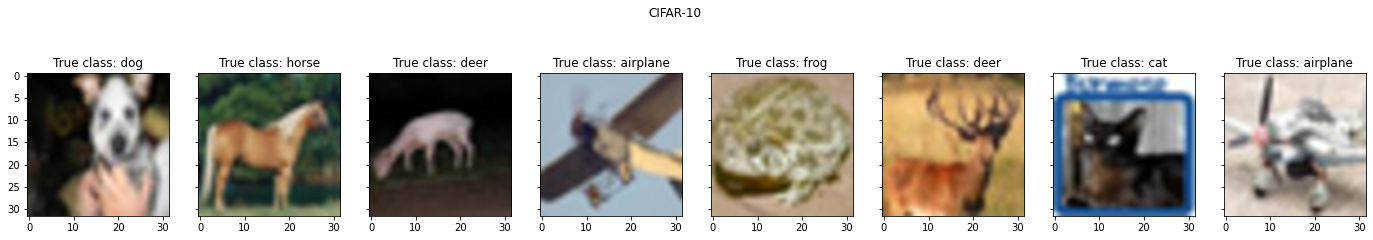

In [3]:
# Load CIFAR-10 dataset & check data dimension
# Ref: Homepage: https://www.cs.toronto.edu/~kriz/cifar.html

print('== Reading raw dataset ==')
(X_train_raw, y_train), (X_test_raw, y_test) = tf.keras.datasets.cifar10.load_data() 

print("X_train_raw:",X_train_raw.shape, " as ", X_train_raw.dtype)
print("y_train:",y_train.shape, " as ", y_train.dtype)
print("X_test_raw: ",X_test_raw.shape, " as ", X_test_raw.dtype)
print("y_test: ",y_test.shape, " as ", y_test.dtype)

# Define classes names
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
N_classes = len(class_names)

# Plot a couple of pictures for fun
Npics=8
fig, ax = plt.subplots(nrows=1, ncols=Npics, figsize=(Npics*3,4), sharey=True)
fig.suptitle('CIFAR-10')
for i in range(Npics):
  rnd = np.random.randint(1000)
  ax[i].imshow(X_train_raw[rnd,:,:,:], interpolation='spline16')
  ax[i].set_title (str("True class: "+class_names[y_train[rnd][0]]))


In [4]:
### Normalization of training & test datasets
print("== Normalized data shapes ==")
X_train = X_train_raw.astype(np.float32) /255.0
X_test = X_test_raw.astype(np.float32) / 255.0

# OR

### Standardization over whole dataset but each RGB channel independently")

# print("== Standardized data shape ==")
# X_train_mean = np.mean(X_train_raw.astype(np.float32), axis=(0,1,2))
# X_train_std = np.std(X_train_raw.astype(np.float32), axis=(0,1,2))
# X_train = (X_train_raw.astype(np.float32) - X_train_mean) / X_train_std
# X_test = (X_test_raw.astype(np.float32) - X_train_mean) / X_train_std

print("X_train_raw:",X_train.shape, " as ", X_train.dtype)
print("X_test_raw: ",X_test.shape, " as ", X_train.dtype)
print()

print("== 1st image ==\n RGB channel average:",X_train[0,:,:,:].mean(axis=(0,1)))
print(" RGB channel min:",X_train[0,:,:,:].min(axis=(0,1)))
print(" RGB channel max:",X_train[0,:,:,:].max(axis=(0,1)))

== Normalized data shapes ==
X_train_raw: (50000, 32, 32, 3)  as  float32
X_test_raw:  (10000, 32, 32, 3)  as  float32

== 1st image ==
 RGB channel average: [0.5537454  0.41215533 0.25112593]
 RGB channel min: [0. 0. 0.]
 RGB channel max: [1.         0.99215686 0.92156863]


In [5]:
# Hot encoding of labels (not strictly necessary, depends on selected loss function)
print ('== Hot encoding of labels ==')
y_train_cat = to_categorical (y_train).astype(np.uint8)
y_test_cat = to_categorical (y_test).astype(np.uint8)

print("y_train_cat:",y_train_cat.shape, " as ", y_train_cat.dtype)
print("y_test_cat: ",y_test_cat.shape, " as ", y_test_cat.dtype)

print('Example: ',y_train_cat[0])


== Hot encoding of labels ==
y_train_cat: (50000, 10)  as  uint8
y_test_cat:  (10000, 10)  as  uint8
Example:  [0 0 0 0 0 0 1 0 0 0]


== Image augmentation ==


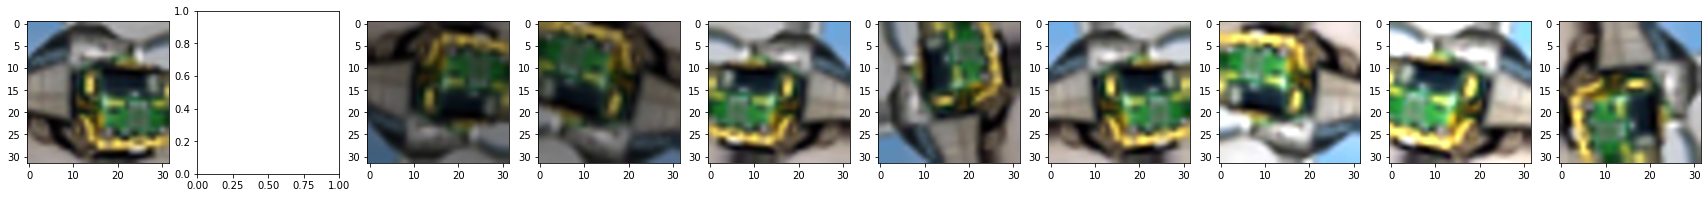

In [8]:
# Dataset augmentation 
print ('== Image augmentation ==')

def orthogonal_rot(image):
    """Randomly rotate an image by 90deg (clock or anticlock wise)

    Args:
        image ([numpy array]): Image

    Returns:
        [numpy array]: Rotated Image
    """
    return np.rot90(image, np.random.choice([-1, 0, 1],p=[0.25, 0.5, 0.25]))

datagen = ImageDataGenerator(
            rescale = 1./255,
            # featurewise_center=True, #### average done on whole dataset
            # featurewise_std_normalization=True,             
            # samplewise_center=True,  #### average done on each image
            # samplewise_std_normalization=True,    
            # zca_whitening=True, 
            # zca_epsilon=2, 
            rotation_range=15,
            zoom_range=[0.9, 1.1],
            # width_shift_range=0.05,
            # height_shift_range=0.05,
            fill_mode="nearest",
            # cval=0.0,
            # channel_shift_range=32, 
            # shear_range=15,
            brightness_range=[0.4,1.5],
            horizontal_flip=True, 
            vertical_flip=True, 
            preprocessing_function=orthogonal_rot, 
            # data_format='channels_last', 
            # validation_split=0.2, 
            # dtype='float32'
            )
datagen.fit(X_train_raw)  # only required if stats are required (ie using ZCA, feature/sample-wise augmentations)


def show_augmentation(datagen, X, n_pics=5):
    """"
    Synopsis: Randomly select an image from a dataset and plots a few augmented image variants 
              The first picture on the left is the original picture from cifar-10 dataset.
    Args: 
        datagen: ImageDataGenerator class
        X: image dataset as a 4d numpy tensor
        n_pics: number of augmented variants to display
        
        Output: None
    """
    rnd = np.random.randint(X.shape[0])
    img_iterator = datagen.flow(X[rnd].reshape(1, 32, 32, 3), batch_size=1)

    fig, ax = plt.subplots(nrows=1, ncols=n_pics+2, figsize=((n_pics+2)*3, 3))
    ax[0].imshow(X[rnd].reshape(32,32,3), interpolation='spline16') 
    # ax[1].axis('off')
    for i in range(n_pics):
        # ax[i+2].axis('off')
        img = img_iterator.next().reshape(32,32,3)
        # ax[i+2].imshow(img.astype('uint8')) ### use when no rescaling defined in ImageDataGenerator
        ax[i+2].imshow(img, interpolation='spline16') 

show_augmentation(datagen, X_train_raw[10:15], 8) # Must be passed dataset used during Generator fit 


In [10]:
# Some helper functions
 
def plot_evaluation (history_pd):
    """
    Synopsis: Plot loss and accuracy convergence histories for training and validation datasets 

    Args:
        history_pd: panda dataframe containg cvg history from the Keras model fit function
    
    Returns: None
    """
    Nfigs = int(len(history_pd.columns)/2)
    fig, ax = plt.subplots(nrows=1, ncols=Nfigs, figsize=(Nfigs*5,3))
    fig.suptitle('CIFAR-10 evaluation')

    for i in range(Nfigs):
        history_pd.iloc[:,i].plot(ax=ax[i], label='Training ') 
        history_pd.iloc[:,i+Nfigs].plot(ax=ax[i], label='Validation ')
        ax[i].set_title(history_pd.columns[i])
        ax[i].legend()
        ax[i].grid(True)
        ax[i].set_xlabel('epochs')

def lr_schedule(epoch, lr):
    """
    Synopsis: Learning rate callback function, reduces LR after a certain number of Epochs

    Args:
        epoch: current epoch
        lr: current learning rate

    Returns:
        [float]: updated learning rate
    """
    if epoch < 10:
        return lr
    else:
        return lr * 0.9


In [15]:
# Model architecture

def build_VGG16_model (myLoss="categorical_crossentropy", myOptimizer="adam", myMetrics=["accuracy"], myActivation='relu', myDropout_Conv=0.25, myDropout_Dense=0.25):
    """Build a VGG-16 model

    Args:
        myLoss (str, optional): Keras loss model. Defaults to "categorical_crossentropy".
        myOptimizer (str, optional): Keras optimizer. Defaults to "adam".
        myMetrics (str, optional): Metrics to be used. Defaults to ["accuracy"].
        myActivation (str, optional): Activation function for both convolution and Dense FC layers. Defaults to 'relu'.
        myDropout_Conv (float, optional): Dropout rate for convolution layers. Defaults to 0.25.
        myDropout_Dense (float, optional): Dropout rate for Dense FC layers. Defaults to 0.25.

    Returns:
        [tensorflow.python.keras.engine.sequential.Sequential]: Sequential class model
    """

    # VGG model has a sequential architecture
    model = Sequential()
    
    # stage 1: 2 convoltions with BN, activation, then MaxPooling and dropout
    model.add(Conv2D(filters=64,kernel_size=(3,3), padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(Conv2D(filters=64, padding='same', kernel_size=(3,3)))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(myDropout_Conv))

    # stage 2: 2 convoltions with BN, activation, then MaxPooling and dropout
    model.add(Conv2D(filters=128,kernel_size=(3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(Conv2D(filters=128, padding='same', kernel_size=(3,3)))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(myDropout_Conv))

    # stage 3: 2 convoltions with BN, activation, then MaxPooling and dropout
    model.add(Conv2D(filters=256,kernel_size=(3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(Conv2D(filters=256, padding='same', kernel_size=(3,3)))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(myDropout_Conv))

    # stage 4: 3 convoltions with BN, activation, then MaxPooling and dropout
    model.add(Conv2D(filters=512,kernel_size=(3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(Conv2D(filters=512, padding='same', kernel_size=(3,3)))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(Conv2D(filters=512, padding='same', kernel_size=(3,3)))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(myDropout_Conv))

    # stage 5: 3 convoltions with BN, activation, then MaxPooling and dropout
    model.add(Conv2D(filters=512,kernel_size=(3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(Conv2D(filters=512, padding='same', kernel_size=(3,3)))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(Conv2D(filters=512, padding='same', kernel_size=(3,3)))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(myDropout_Conv))

    # Flattening
    model.add(Flatten())

    # Fully connected layer with dropout
    model.add(Dense(2048))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(Dropout(myDropout_Dense))
    
    # Fully connected layer with dropout
    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(Dropout(myDropout_Dense))
    
    # Fully connected layer with dropout
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(Dropout(myDropout_Dense))
    
    # Fully connected layer with dropout
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(Dropout(myDropout_Dense))
    
    # Fully connected layer withSoftmax activation
    model.add(Dense(10, activation='softmax'))

    # Compiling model
    model.compile(loss=myLoss, optimizer=myOptimizer, metrics=myMetrics) 

    return model
    

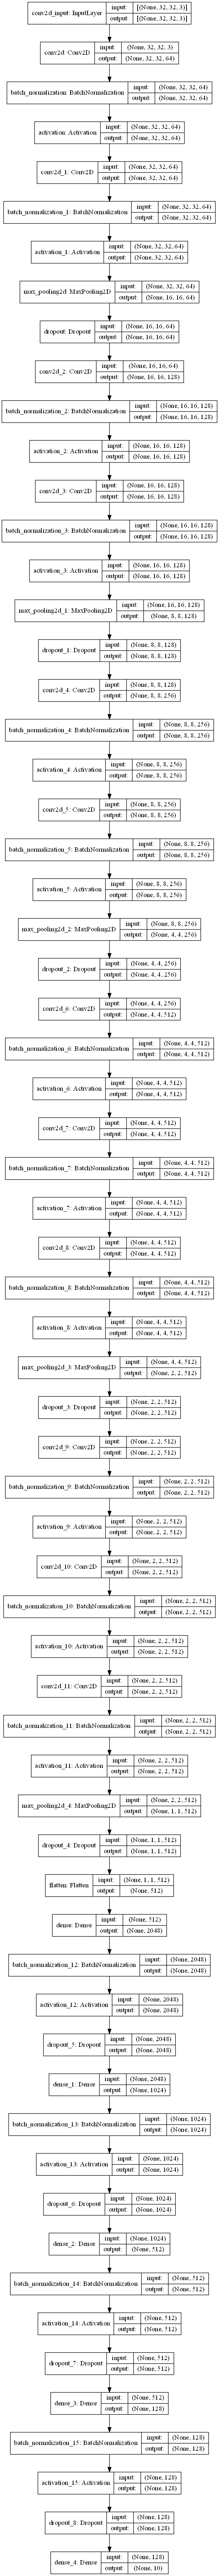

In [13]:
#### RUN PARAMETERS
batch_size = 256 
N_epochs = 300
N_steps = X_train.shape[0] // batch_size

#### OPTIMIZERS
# lr_ExpDecay = ExponentialDecay(initial_learning_rate = 0.01, decay_steps = N_steps * 10, decay_rate = 0.85, staircase=True)
# myOptimizer = SGD(learning_rate=0.001)
# myOptimizer = SGD(learning_rate=lr_ExpDecay, decay=1e-6, momentum=0.9)  
# myOptimizer = SGD(learning_rate=lr_ExpDecay, decay=1e-6, momentum=0.9, nesterov=True)
# myOptimizer = RMSprop(learning_rate=0.01, decay=1e-06)
# myOptimizer = Adam(learning_rate=0.001, epsilon=1e-08)
myOptimizer = Adam(learning_rate=0.0005, epsilon=1e-08, amsgrad=True)


#### LOSSES
# myLoss = "sparse_categorical_crossentropy" 
myLoss = "categorical_crossentropy" 
# myLoss = "mse"

#### METRICS
myMetrics = ["accuracy"] #,Precision(name='precision'), Recall(name='recall')]

#### ACTIVATION
# myActivation = 'relu'
myActivation = LeakyReLU()

#### CALLBACKS
logdir = "logs/scalars/" + filename  # datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_CB = TensorBoard(log_dir=logdir, histogram_freq=1)
# early_stop = EarlyStopping(monitor='val_loss', mode="min", patience=4)
# LR_scheduler = LearningRateScheduler(lr_schedule)
# RonP = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
myCallbacks = [tensorboard_CB] 


##### BUILD MODEL
model = build_VGG16_model (myLoss, myOptimizer, myMetrics, myActivation, myDropout_Conv=0.5, myDropout_Dense=0.5)

##### MODEL overview
# model.summary()
plot_model(model, to_file=filename+'.png', show_shapes=True, show_layer_names=True)

##### MONITORING (optional)
# %tensorboard --logdir logs/scalars   # Tensorboard used locally instead (launch from cmd line "tensorboard --logdir logs/scalars" in working directory)

Running 300 Epochs (batch size 256) with 195steps/epoch
Epoch 1/300
195/195 [==============================] - 47s 188ms/step - loss: 2.5991 - accuracy: 0.1253 - val_loss: 2.8533 - val_accuracy: 0.1079
Epoch 2/300
195/195 [==============================] - 33s 167ms/step - loss: 2.1206 - accuracy: 0.2050 - val_loss: 2.6750 - val_accuracy: 0.1227
Epoch 3/300
195/195 [==============================] - 32s 164ms/step - loss: 1.9147 - accuracy: 0.2733 - val_loss: 2.3857 - val_accuracy: 0.2281
Epoch 4/300
195/195 [==============================] - 32s 163ms/step - loss: 1.8008 - accuracy: 0.3087 - val_loss: 2.1403 - val_accuracy: 0.3024
Epoch 5/300
195/195 [==============================] - 32s 164ms/step - loss: 1.7041 - accuracy: 0.3413 - val_loss: 1.7873 - val_accuracy: 0.3608
Epoch 6/300
195/195 [==============================] - 32s 162ms/step - loss: 1.6160 - accuracy: 0.3766 - val_loss: 1.7366 - val_accuracy: 0.4035
Epoch 7/300
195/195 [==============================] - 32s 164ms/ste

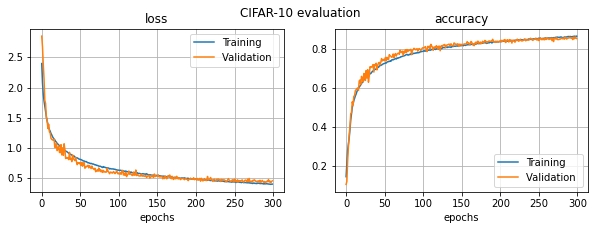

In [19]:
# Run 1: Fit model on augmented data with large bath and fixed learning rate 
 
training_generator = datagen.flow(X_train_raw, y_train_cat, batch_size=batch_size)
# training_generator = datagen.flow(X_train_raw, y_train_cat, batch_size=batch_size, subset='training')
validation_generator = datagen.flow(X_test_raw, y_test_cat, batch_size=batch_size)

print(f'Running {N_epochs} Epochs (batch size {batch_size}) with {N_steps}steps/epoch' )

history = model.fit(
                    training_generator,
                    # X_train, y_train_cat, 
                    epochs = N_epochs, 
                    steps_per_epoch = N_steps,
                    # shuffle=True, 
                    validation_data=validation_generator, 
                    # validation_data=(X_test, y_test_cat), 
                    callbacks = myCallbacks,
                    verbose=1,
                    )

## Update convergence history and plot loss & accuracy
pd_history = pd.DataFrame(history.history) 
plot_evaluation (pd_history)

## Evaluate Model performance
training = model.evaluate(X_train, y_train_cat)
evaluation = model.evaluate(X_test, y_test_cat)

In [20]:
# Save model and convergence history

model_filename = filename+"_run1.tf"
model.save(model_filename, overwrite=False, include_optimizer=True, save_traces=True)

pd_history.to_csv(filename+"_run1.csv")

INFO:tensorflow:Assets written to: cifar10-v3.2_run1.tf\assets


INFO:tensorflow:Assets written to: cifar10-v3.2_run1.tf\assets


## Run 1 NOTES (observations & suggestions):
- Good improvement from the VGG-16 model (cifar-10_v3.2 with val_acc=84.3%) on augmented data compared to VGG-10 (cifar-10_v2.20 with val_acc=80.0%)
- There is a clear improvement in data overfitting. Deeper VGG-16 model reaches better regularization on test data.
- VGG-16 model training & validation losses (val_loss=0.497) reduced to a level below VGG-10 model (cifar-10_v2.20 with val_loss=0.582)
- however it looks like the model is beginning to overfit
- suggestion: reduce the batch size and learning rate (maybe in two separate steps)

Running 100 Epochs (batch size 128) with 390steps/epoch
Epoch 1/100
390/390 [==============================] - 36s 91ms/step - loss: 0.4631 - accuracy: 0.8446 - val_loss: 0.4880 - val_accuracy: 0.8441
Epoch 2/100
390/390 [==============================] - 34s 86ms/step - loss: 0.4744 - accuracy: 0.8412 - val_loss: 0.4859 - val_accuracy: 0.8364
Epoch 3/100
390/390 [==============================] - 34s 88ms/step - loss: 0.4716 - accuracy: 0.8414 - val_loss: 0.4537 - val_accuracy: 0.8488
Epoch 4/100
390/390 [==============================] - 35s 88ms/step - loss: 0.4754 - accuracy: 0.8385 - val_loss: 0.4468 - val_accuracy: 0.8481
Epoch 5/100
390/390 [==============================] - 34s 88ms/step - loss: 0.4638 - accuracy: 0.8438 - val_loss: 0.4620 - val_accuracy: 0.8496
Epoch 6/100
390/390 [==============================] - 34s 88ms/step - loss: 0.4693 - accuracy: 0.8438 - val_loss: 0.4933 - val_accuracy: 0.8372
Epoch 7/100
390/390 [==============================] - 35s 89ms/step - los

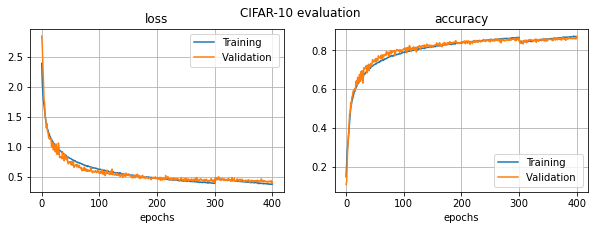

In [24]:
# RUN 2: Fit model on augmented data with reduced batch size to iterate gradient more often and reduce instabilities
 
#### RUN PARAMETERS
batch_size = 128 
N_epochs = 100
N_steps = X_train.shape[0] // batch_size

training_generator = datagen.flow(X_train_raw, y_train_cat, batch_size=batch_size)
# training_generator = datagen.flow(X_train_raw, y_train_cat, batch_size=batch_size, subset='training')
validation_generator = datagen.flow(X_test_raw, y_test_cat, batch_size=batch_size)

print(f'Running {N_epochs} Epochs (batch size {batch_size}) with {N_steps}steps/epoch' )

history = model.fit(
                    training_generator,
                    # X_train, y_train_cat, 
                    epochs = N_epochs, 
                    steps_per_epoch = N_steps,
                    # shuffle=True, 
                    validation_data=validation_generator, 
                    # validation_data=(X_test, y_test_cat), 
                    callbacks = myCallbacks,
                    verbose=1,
                    )

## Update convergence history and plot loss & accuracy
# pd_history = pd.DataFrame(history.history) 
pd_history_old = pd_history
pd_history = pd_history.append(pd.DataFrame(history.history)  , ignore_index=True)

plot_evaluation (pd_history)

## Evaluate Model performance
training = model.evaluate(X_train, y_train_cat)
evaluation = model.evaluate(X_test, y_test_cat)

In [25]:
# Save model and convergence history

model_filename = filename+"_run2.tf"
model.save(model_filename, overwrite=False, include_optimizer=True, save_traces=True)

pd_history.to_csv(filename+"_run2.csv")

INFO:tensorflow:Assets written to: cifar10-v3.2_run2.tf\assets


INFO:tensorflow:Assets written to: cifar10-v3.2_run2.tf\assets


## RUN 2 NOTES (observations & suggestions):
- a jump in accuracy and loss related to batch size was not really a surprise. The model back-propagates the loss more often which is good but not enough to significantly reduce losses. A reduction in learning rate is required to fine tune the model.
- In addition, although the training & validation losses have reduced further, it still looks like the model is beginning to overfit
- suggestion: reduce learning rate 

Running 100 Epochs (batch size 128) with 390steps/epoch
Epoch 1/100
390/390 [==============================] - 42s 100ms/step - loss: 0.3567 - accuracy: 0.8804 - val_loss: 0.3842 - val_accuracy: 0.8733
Epoch 2/100
390/390 [==============================] - 35s 89ms/step - loss: 0.3409 - accuracy: 0.8850 - val_loss: 0.3880 - val_accuracy: 0.8765
Epoch 3/100
390/390 [==============================] - 34s 88ms/step - loss: 0.3394 - accuracy: 0.8852 - val_loss: 0.3943 - val_accuracy: 0.8700
Epoch 4/100
390/390 [==============================] - 34s 88ms/step - loss: 0.3251 - accuracy: 0.8914 - val_loss: 0.3760 - val_accuracy: 0.8769
Epoch 5/100
390/390 [==============================] - 34s 87ms/step - loss: 0.3364 - accuracy: 0.8853 - val_loss: 0.3883 - val_accuracy: 0.8772
Epoch 6/100
390/390 [==============================] - 35s 89ms/step - loss: 0.3248 - accuracy: 0.8902 - val_loss: 0.3888 - val_accuracy: 0.8750
Epoch 7/100
390/390 [==============================] - 34s 88ms/step - lo

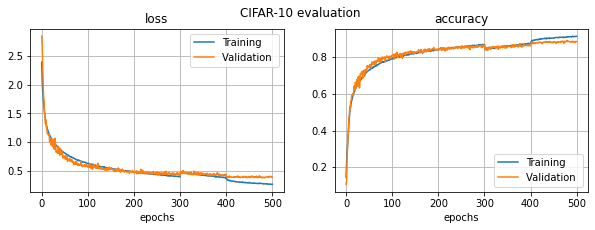

In [26]:
# RUN 3: Fit model on augmented data with reduced learning rate to reduce loss
 
#### RUN PARAMETERS
batch_size = 128 
N_epochs = 100
N_steps = X_train.shape[0] // batch_size
myOptimizer = Adam(learning_rate=0.0001, epsilon=1e-08, amsgrad=True)
model.compile(loss=myLoss, optimizer=myOptimizer, metrics=myMetrics) 

training_generator = datagen.flow(X_train_raw, y_train_cat, batch_size=batch_size)
# training_generator = datagen.flow(X_train_raw, y_train_cat, batch_size=batch_size, subset='training')
validation_generator = datagen.flow(X_test_raw, y_test_cat, batch_size=batch_size)

print(f'Running {N_epochs} Epochs (batch size {batch_size}) with {N_steps}steps/epoch' )

history = model.fit(
                    training_generator,
                    # X_train, y_train_cat, 
                    epochs = N_epochs, 
                    steps_per_epoch = N_steps,
                    # shuffle=True, 
                    validation_data=validation_generator, 
                    # validation_data=(X_test, y_test_cat), 
                    callbacks = myCallbacks,
                    verbose=1,
                    )

## Update convergence history and plot loss & accuracy
# pd_history = pd.DataFrame(history.history) 
pd_history_old = pd_history
pd_history = pd_history.append(pd.DataFrame(history.history)  , ignore_index=True)

plot_evaluation (pd_history)

## Evaluate Model performance
training = model.evaluate(X_train, y_train_cat)
evaluation = model.evaluate(X_test, y_test_cat)

In [27]:
# Save model and convergence history

model_filename = filename+"_run3.tf"
model.save(model_filename, overwrite=False, include_optimizer=True, save_traces=True)

pd_history.to_csv(filename+"_run3.csv")

INFO:tensorflow:Assets written to: cifar10-v3.2_run3.tf\assets


INFO:tensorflow:Assets written to: cifar10-v3.2_run3.tf\assets


## Run 3 NOTES (observations & suggestions):
- The training loss reduces further but the validation loss has definitely now reached a plateau
- the model is now overfitting despite all regulation techniques used (BN, dropout, image augmentation)
- suggestion: reduce the learning rate and batch size further to check if that yields any improvement

Running 50 Epochs (batch size 64) with 781steps/epoch
Epoch 1/50
781/781 [==============================] - 46s 55ms/step - loss: 0.2790 - accuracy: 0.9061 - val_loss: 0.4026 - val_accuracy: 0.8767
Epoch 2/50
781/781 [==============================] - 37s 48ms/step - loss: 0.2755 - accuracy: 0.9058 - val_loss: 0.3910 - val_accuracy: 0.8813
Epoch 3/50
781/781 [==============================] - 35s 45ms/step - loss: 0.2715 - accuracy: 0.9078 - val_loss: 0.3876 - val_accuracy: 0.8827
Epoch 4/50
781/781 [==============================] - 36s 46ms/step - loss: 0.2772 - accuracy: 0.9071 - val_loss: 0.3841 - val_accuracy: 0.8839
Epoch 5/50
781/781 [==============================] - 37s 48ms/step - loss: 0.2752 - accuracy: 0.9066 - val_loss: 0.3880 - val_accuracy: 0.8799
Epoch 6/50
781/781 [==============================] - 35s 45ms/step - loss: 0.2717 - accuracy: 0.9084 - val_loss: 0.3714 - val_accuracy: 0.8836
Epoch 7/50
781/781 [==============================] - 36s 45ms/step - loss: 0.2731

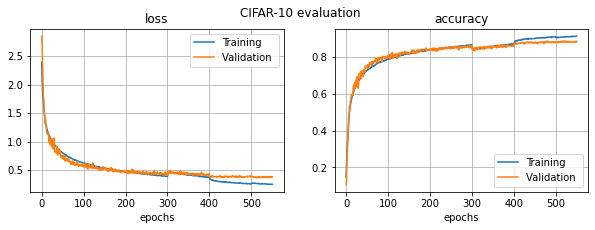

In [28]:
# RUN 4: Fit model on augmented data with both reduced learning rate and batch size to reduce loss & instabilities 
 
 #### RUN PARAMETERS
batch_size = 64 
N_epochs = 50
N_steps = X_train.shape[0] // batch_size
myOptimizer = Adam(learning_rate=0.00005, epsilon=1e-08, amsgrad=True)
model.compile(loss=myLoss, optimizer=myOptimizer, metrics=myMetrics) 

training_generator = datagen.flow(X_train_raw, y_train_cat, batch_size=batch_size)
# training_generator = datagen.flow(X_train_raw, y_train_cat, batch_size=batch_size, subset='training')
validation_generator = datagen.flow(X_test_raw, y_test_cat, batch_size=batch_size)

print(f'Running {N_epochs} Epochs (batch size {batch_size}) with {N_steps}steps/epoch' )

history = model.fit(
                    training_generator,
                    # X_train, y_train_cat, 
                    epochs = N_epochs, 
                    steps_per_epoch = N_steps,
                    shuffle=True, 
                    validation_data=validation_generator, 
                    # validation_data=(X_test, y_test_cat), 
                    callbacks = myCallbacks,
                    verbose=1,
                    )

## Update convergence history and plot loss & accuracy

# pd_history = pd.DataFrame(history.history) 
pd_history_old = pd_history
pd_history = pd_history.append(pd.DataFrame(history.history)  , ignore_index=True)

plot_evaluation (pd_history)

## Evaluate Model performance
training = model.evaluate(X_train, y_train_cat)
evaluation = model.evaluate(X_test, y_test_cat)

In [29]:
# Save model and convergence history

model_filename = filename+"_run4.tf"
model.save(model_filename, overwrite=False, include_optimizer=True, save_traces=True)

pd_history.to_csv(filename+"_run4.csv")

INFO:tensorflow:Assets written to: cifar10-v3.2_run4.tf\assets


INFO:tensorflow:Assets written to: cifar10-v3.2_run4.tf\assets


## Run 4 NOTES (observations & suggestions):
- The training loss reduces further but the validation loss is still "plateau-ing"
- the model isdefinitely overfitting despite all regulation techniques used (BN, dropout, image augmentation) and reduce learning rates & batch size
- the data augmentation routine randomly combines many different type of modifications
- one could maybe squeeze some additional accuracy points by training on the original dataset at low learning rate & batch size
- suggestion: train on the original dataset from this already train model (sort of transfer learning)

313/313 [==============================] - 3s 8ms/step - loss: 0.4350 - accuracy: 0.8732


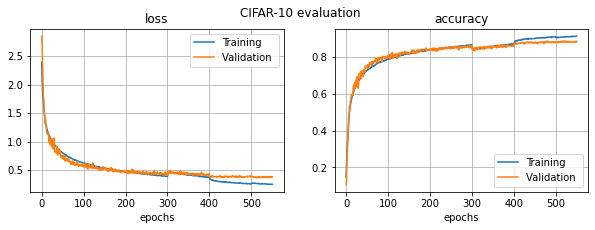

In [ ]:
# RELOAD MODEL from RUN 4 and evaluate loss & accuracy to confirm model loaded correctly

model = load_model('cifar10-v3.2_run4.tf')

pd_history = pd.read_csv('cifar10-v3.2_run4.csv')
pd_history = pd_history.drop(pd_history.columns[[0]], axis=1)

plot_evaluation (pd_history)

training = model.evaluate(X_train, y_train_cat)
evaluation = model.evaluate(X_test, y_test_cat)

# Update filename not to override previously saved model & convergence history
filename = "cifar10-v3.3"

Running 100 Epochs (batch size 32) with 1562steps/epoch
Epoch 1/100
1562/1562 [==============================] - 58s 35ms/step - loss: 0.2568 - accuracy: 0.9132 - val_loss: 0.3240 - val_accuracy: 0.9022
Epoch 2/100
1562/1562 [==============================] - 52s 33ms/step - loss: 0.2131 - accuracy: 0.9272 - val_loss: 0.3047 - val_accuracy: 0.9066
Epoch 3/100
1562/1562 [==============================] - 52s 34ms/step - loss: 0.1990 - accuracy: 0.9324 - val_loss: 0.3224 - val_accuracy: 0.9020
Epoch 4/100
1562/1562 [==============================] - 51s 33ms/step - loss: 0.1884 - accuracy: 0.9369 - val_loss: 0.3014 - val_accuracy: 0.9078
Epoch 5/100
1562/1562 [==============================] - 52s 33ms/step - loss: 0.1826 - accuracy: 0.9375 - val_loss: 0.3076 - val_accuracy: 0.9083
Epoch 6/100
1562/1562 [==============================] - 51s 33ms/step - loss: 0.1805 - accuracy: 0.9381 - val_loss: 0.3048 - val_accuracy: 0.9073
Epoch 7/100
1562/1562 [==============================] - 51s 3

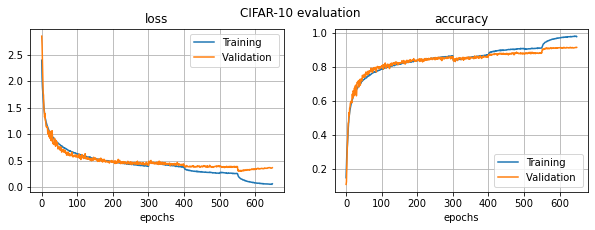

In [ ]:
# RUN 5: Fit model on original CIFAR-10 dataset with same learning rate but reduced batch size compared to RUN 4 
 
#### RUN PARAMETERS
batch_size = 32 
N_epochs = 100
N_steps = X_train.shape[0] // batch_size
myOptimizer = Adam(learning_rate=0.00005, epsilon=1e-08, amsgrad=True)
model.compile(loss=myLoss, optimizer=myOptimizer, metrics=myMetrics) 

training_generator = datagen.flow(X_train_raw, y_train_cat, batch_size=batch_size)
# training_generator = datagen.flow(X_train_raw, y_train_cat, batch_size=batch_size, subset='training')
validation_generator = datagen.flow(X_test_raw, y_test_cat, batch_size=batch_size)

print(f'Running {N_epochs} Epochs (batch size {batch_size}) with {N_steps}steps/epoch' )

history = model.fit(
                    # training_generator,
                    X_train, y_train_cat, 
                    epochs = N_epochs, 
                    steps_per_epoch = N_steps,
                    # shuffle=True, 
                    # validation_data=validation_generator, 
                    validation_data=(X_test, y_test_cat), 
                    callbacks = myCallbacks,
                    verbose=1,
                    )

## Update convergence history and plot loss & accuracy

# pd_history = pd.DataFrame(history.history) 
pd_history_old = pd_history
pd_history = pd_history.append(pd.DataFrame(history.history)  , ignore_index=True)

plot_evaluation (pd_history)

## Evaluate Model performance
training = model.evaluate(X_train, y_train_cat)
evaluation = model.evaluate(X_test, y_test_cat)

In [ ]:
# Save model and convergence history

model_filename = filename+"_run1.tf"
model.save(model_filename, overwrite=False, include_optimizer=True, save_traces=True)

pd_history.to_csv(filename+"_run1.csv")

INFO:tensorflow:Assets written to: cifar10-v3.3_run1.tf\assets


INFO:tensorflow:Assets written to: cifar10-v3.3_run1.tf\assets


## Run 5 NOTES (observations & suggestions):
- Resuming the model at run 4 and fitting the original dataset with a reduced batch size immediately improves loss and accuracy: 
  --> Run4_end (val_loss=0.4350, val_acc=0.8732) vs Run5_start (val_loss=0.3240, val_acc=0.9022)  
- After RUN5 completed a few things are noteworthy:
  - 1. both training and validation accuracies have greatly improved during RUN5 (train_acc: from 0.9132 to 0.9807, validation: from 0.9022 to 0.9170) compared to RUN4 (train_acc=0.9543, val_acc=0.8732)
  - 2. the training loss has greatly reduced (train_loss: from 0.2568 to 0.0585) whereas the validation loss has slightly increased (val_loss: from 0.3240 to 0.3641)
  - 3. Although validation loss has slightly increased during RUN5, it is still at a lower level than RUN4 (val_loss: 0.3641 vs val_loss=0.4350)
  - 4. Although the model is overfitting slightly, the training on the original dataset has yielded some improvements on validation accuracy  
- Since the reduction in batch size has yielded some validation accuracy improvement it would be interesting to try and reduce learning rate and batch size further
- suggestion: reduce the learning rate and batch size further to check if that yields any improvement

Running 100 Epochs (batch size 16) with 3125steps/epoch
Epoch 1/100
3125/3125 [==============================] - 98s 31ms/step - loss: 0.0847 - accuracy: 0.9737 - val_loss: 0.3538 - val_accuracy: 0.9175
Epoch 2/100
3125/3125 [==============================] - 89s 28ms/step - loss: 0.0770 - accuracy: 0.9767 - val_loss: 0.3484 - val_accuracy: 0.9151
Epoch 3/100
3125/3125 [==============================] - 85s 27ms/step - loss: 0.0737 - accuracy: 0.9759 - val_loss: 0.3381 - val_accuracy: 0.9177
Epoch 4/100
3125/3125 [==============================] - 84s 27ms/step - loss: 0.0749 - accuracy: 0.9776 - val_loss: 0.3448 - val_accuracy: 0.9187
Epoch 5/100
3125/3125 [==============================] - 85s 27ms/step - loss: 0.0743 - accuracy: 0.9770 - val_loss: 0.3414 - val_accuracy: 0.9175
Epoch 6/100
3125/3125 [==============================] - 84s 27ms/step - loss: 0.0697 - accuracy: 0.9783 - val_loss: 0.3390 - val_accuracy: 0.9175
Epoch 7/100
3125/3125 [==============================] - 85s 2

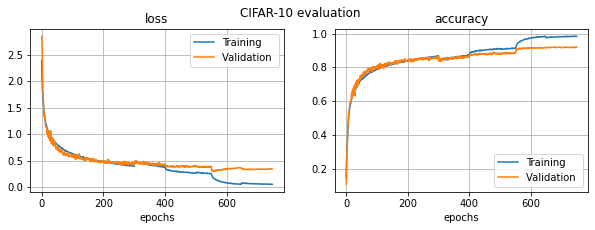

In [ ]:
# RUN 6: Fit model on original CIFAR-10 dataset with reduced learning rate and batch size 
 
#### RUN PARAMETERS
batch_size = 16 
N_epochs = 100
N_steps = X_train.shape[0] // batch_size
myOptimizer = Adam(learning_rate=0.00001, epsilon=1e-08, amsgrad=True)
model.compile(loss=myLoss, optimizer=myOptimizer, metrics=myMetrics) 

training_generator = datagen.flow(X_train_raw, y_train_cat, batch_size=batch_size)
# training_generator = datagen.flow(X_train_raw, y_train_cat, batch_size=batch_size, subset='training')
validation_generator = datagen.flow(X_test_raw, y_test_cat, batch_size=batch_size)

print(f'Running {N_epochs} Epochs (batch size {batch_size}) with {N_steps}steps/epoch' )

history = model.fit(
                    # training_generator,
                    X_train, y_train_cat, 
                    epochs = N_epochs, 
                    steps_per_epoch = N_steps,
                    # shuffle=True, 
                    # validation_data=validation_generator, 
                    validation_data=(X_test, y_test_cat), 
                    callbacks = myCallbacks,
                    verbose=1,
                    )

## Update convergence history and plot loss & accuracy

# pd_history = pd.DataFrame(history.history) 
pd_history_old = pd_history
pd_history = pd_history.append(pd.DataFrame(history.history)  , ignore_index=True)

plot_evaluation (pd_history)

## Evaluate Model performance
training = model.evaluate(X_train, y_train_cat)
evaluation = model.evaluate(X_test, y_test_cat)

In [ ]:
# Save model and convergence history
 
model_filename = filename+"_run2.tf"
model.save(model_filename, overwrite=False, include_optimizer=True, save_traces=True)

pd_history.to_csv(filename+"_run2.csv")

INFO:tensorflow:Assets written to: cifar10-v3.3_run2.tf\assets


INFO:tensorflow:Assets written to: cifar10-v3.3_run2.tf\assets


## Run 6 NOTES (observations & suggestions):
- both training and validation accuracies have improved as a result of lowering batch soze and learning rate:
  - train_acc: from 0.9807 to 1.0, validation: from 0.9170 to 0.921
- Similarly both training and validation losses have reduced slightly
  -  train_loss: from 0.0585 to 0.0003, val_loss: from 0.3641 to 0.338
- I think we've reached the limit of the VGG-16 model architecture and there would only be very limited gain to reduce learning rate and run further 
- suggestion: investigate a different model architecture, maybe an inception model like GoogleLeNet